In [1]:
%%time

%cd "~/lab/NB10422645"
from src.surrogate.sampling import uniform_grid


/home/ggarrett/lab/NB10422645
CPU times: user 314 ms, sys: 306 ms, total: 620 ms
Wall time: 130 ms


In [2]:
%%time

import subprocess
from scipy.io import savemat, loadmat
import numpy as np
import os 

from tqdm import tqdm_notebook as tqdm


def pre_constructor(x, v0=0, t0=0, velocity_limit=10, duration=200):
    if len(x)%2==0:
        if len(x)!=2:
            _v = np.concatenate(([v0],x[:len(x)//2])) * velocity_limit
            _t = np.cumsum((np.concatenate(([t0],x[len(x)//2:] + 0.01)))) 
            _t = (_t/np.max(_t)) * duration
        else:
            _v = x * velocity_limit
            _t = np.array([0,1]) * duration
    elif len(x)==3:
        _v = np.concatenate(([v0], x[:2])) * velocity_limit
        _t = np.array([t0, 0.01+ x[-1], 1.01]) * duration
    else:
        raise AssertionError("Nx not recognised.")
    return np.vstack((_t,_v)).T


def ensure_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)
        


def designs_to_folder(designs: np.ndarray, design_dir: os.PathLike):
    """
    Function to save all design sample 'x<i>.mat' files in root_dir
    
    
    :param designs: SxN matrix, where S is number of samples and N is the design dimension. 
    :param root_dir: Directory where the designs are to be saved.
    """
    _len=len(str(len(designs)))
    ensure_exists(design_dir)
    designs_t=tqdm(designs, desc="Saving designs")
    for idx, x in enumerate(designs_t):
        mdict = {'X': pre_constructor(x)}
        savemat(f'{design_dir}/X{idx+1:0{_len}}.mat', mdict)        
    
def grid_design_to_folder(xdim: int, ndim: int, design_folder: os.PathLike, edges=False):
    """
    Function generate and save grid sampled design files.
    
    """
    grid = uniform_grid(np.array([[0]*xdim,[1]*xdim]), ndim, flatten=True, edges=edges)
    designs_to_folder(grid, design_folder)
    return grid

        
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def subprocess_cmd(command):
    process = subprocess.Popen(command,stdout=subprocess.PIPE, shell=True)
    proc_stdout = process.communicate()[0].strip()
    
def run_simulations(design_path, app_path, overwrite=False):
    """
    Runs design files and saves the corresponding performance files.
    """
    files=os.listdir(design_path)
    evaluated=list(filter(lambda x: 'F' in x, files)) 
    if overwrite==False:
        try:
            assert len(evaluated)==0
        except AssertionError:
            raise AssertionError(f"{design_path} already contains evaluated simulation designs. Set overwrite=True to delete existing.")
    elif len(evaluated)!=0:
        to_delete=tqdm(evaluated, desc="Overwriting")
        for f in to_delete:
            os.remove(os.path.join(design_path,f))
    cmds=[f"{app_path} -i {os.path.join(design_path, file)} -o {os.path.join(design_path,file.replace('X','F'))}" for file in files]
    batches=tqdm(list(chunks(cmds, 10)), desc='Simulating')
    for batch in batches:   
        subprocess_cmd(';'.join(batch))
    

import shutil

def get_simulation_results(design_path, delete_folder=True):
    files=os.listdir(design_path)
    out=list(filter(lambda x: 'F' in x, files))
    out.sort()
    _F = np.vstack([loadmat(os.path.join(design_path,fout))['rt_F'][-1] for fout in out]) 
    _S = np.dstack([loadmat(os.path.join(design_path,fout))['rt_S'] for fout in out])   
    if delete_folder:
        shutil.rmtree(design_path)
    return _S,_F

def idoe_ug_screening(sim_name, N, S):
    tag = f"_UG_N{N}_S{S}"
    ROOT_DIR="simulation"
    EVAL_DIR=f"data/{sim_name}/idoe"
    APP_DIR= "apps"
    APP = sim_name
    
    # Generate uniform grid screening sample.
    X = grid_design_to_folder(N, S, os.path.join(ROOT_DIR, EVAL_DIR, APP + tag))
    run_simulations(design_path=os.path.join(ROOT_DIR, EVAL_DIR, APP + tag),
                    app_path=os.path.join(ROOT_DIR, APP_DIR, APP, "src", APP),
                    overwrite=True)
    S, F = get_simulation_results(design_path=os.path.join(ROOT_DIR, EVAL_DIR, APP + tag))
    
    # Save final mat.
    savemat( os.path.join(ROOT_DIR, EVAL_DIR, f'{APP + tag}.mat'), {"X":X, "S":S, "F":F})


CPU times: user 27.5 ms, sys: 8.49 ms, total: 36 ms
Wall time: 34 ms


In [3]:
%%time

N = 3
S = 5
APP = "rs_bicycle"
idoe_ug_screening(APP, N, S)


CPU times: user 142 ms, sys: 54.6 ms, total: 196 ms
Wall time: 49.6 s


In [ ]:
%%time

N = 3
S = 10
APP = "rs_bicycle"
idoe_ug_screening(APP, N, S)

In [ ]:
%%time

N = 3
S = 15
APP = "rs_bicycle"
idoe_ug_screening(APP, N, S)

In [ ]:
%%time

N = 3
S = 20
APP = "rs_bicycle"
idoe_ug_screening(APP, N, S)

In [ ]:
%%time

N = 3
S = 25
APP = "rs_bicycle"
idoe_ug_screening(APP, N, S)

[[0.1 0.1 0.7 0.3 0.1]
 [0.7 0.5 0.1 0.7 0.7]
 [0.1 0.7 0.9 0.1 0.7]
 [0.1 0.3 0.7 0.3 0.3]
 [0.7 0.5 0.3 0.7 0.7]]
[[   183.53301611   1752.12199706   6778.82790896  17329.23698319
   35468.93545111]
 [  1947.38977917   4955.39143501  12140.98518962  25569.75727437
   47307.29392061]
 [  7709.85607171  12877.20790954  22941.62701394  39968.69961629
   66024.01194795]
 [ 19896.69241103  27943.33193793  41606.51389922  62951.82452625
   94044.85005041]
 [ 40933.65931442  52579.52403749  70561.40636274  96944.89252156
  133795.5687453 ]]


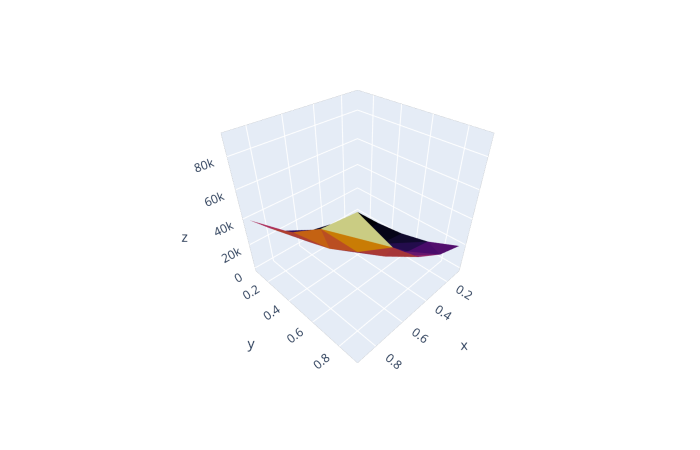

In [42]:
### from src.surrogate.sampling import random_uniform
from src.surrogate.sampling.util import plotly3Dsurf, plotly3Dtrisurf
from src.surrogate.test import *

N=3
S=5
tag = f"_UG_N{N}_S{S}"
ROOT_DIR="simulation"
EVAL_DIR="data/screening"
APP_DIR= "apps"
APP='rs_bicycle'
    
res = loadmat( os.path.join(ROOT_DIR, EVAL_DIR, f'{APP + tag}.mat'))

X = res["X"]
F = res["F"]
s = 2

X=X.reshape(3,5,5,5)

print(X[0][:,:,1])

# print(f)
f_ = F[:,9].reshape(5,5,5)

print(f_[:,:,0])
# print(f_s
f_ = f_[:,:,s]

grid=uniform_grid([[0]*3,[1]*3], 5, flatten=False)

x, y = grid[0][:,:,s], grid[1][:,:,s]

plotly3Dtrisurf(x, y, f_, save=False, renderer="svg")


In [6]:
np.meshgrid([1,0,1], [1,0,1])[0].shape

(3, 3)

In [401]:
import plotly.graph_objects as go



fs = f[:,5].reshape(20,20,20).flatten()

trace1 = go.Scatter3d(
    x = grid[0].flatten(),
    y = grid[1].flatten(),
    z = grid[2].flatten(),
    mode='markers',
    marker=dict(
        size=fs/np.max(fs) * 20,
        color=fs,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.3,
        line=dict(width=0),
        showscale=True
    )
)

data = [trace1]
# layout = go.Layout(
#     scene = dict(
#                     xaxis = dict(
#                         title='XXXX-XXXXXX'),
#                     yaxis = dict(
#                         title='XXXX-XXXXXX'),
#                     zaxis = dict(
#                         title='XXXX-XXXXXX'),),
#     margin=dict(
#         r=20, b=10, l=10, t=10
#     )


fig = go.Figure(data=data)
    
fig.show()
#py.iplot(fig, filename='3d-scatter-colorscale')
# plot(fig, filename='D:\\plots\\3dplots\\xx.html')